<a href="https://colab.research.google.com/github/yorkjong/stock-reports/blob/main/notebooks/ibd_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Setup (this section will be executed automatically)

#### Install Packages

In [1]:
%pip install "git+https://github.com/yorkjong/vistock.git@feature/ibd"
%pip install requests-cache

# ref. https://stackoverflow.com/questions/76593068/plotly-figure-not-rendering-in-ipywidgets-interact-function-google-colab
%pip install plotly==5.10   # avoid plotly-not-rendering-with-ipywidgets issue

  Cloning https://github.com/yorkjong/vistock.git (to revision feature/ibd) to /tmp/pip-req-build-ljd6iutr
  Running command git clone --filter=blob:none --quiet https://github.com/yorkjong/vistock.git /tmp/pip-req-build-ljd6iutr
  Running command git checkout -b feature/ibd --track origin/feature/ibd
  Switched to a new branch 'feature/ibd'
  Branch 'feature/ibd' set up to track remote branch 'feature/ibd' from 'origin'.
  Resolved https://github.com/yorkjong/vistock.git to commit ce7307938340d749b8fa9fe1e145958919f98e1e
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00
  Created wheel for vistock: filename=vistock-0.4.0-py3-none-any.whl size=54731 sha256=6d21c5294e96c8903cf1aa195626e8a8325200fa613d4cb4077896469563a02d
  Stored in directory: /tmp/pip-ephem-wheel-cache-wn48xmsl/wheels/07/97/7f/a72c7fbc975be0326ac45fec1ca0c872e2d6e2bbea96caf706
Successfully built vistock
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4

In [2]:
# @title Install Cache
import requests_cache
requests_cache.install_cache('ibd_cache', expire_after=3600)

#### Setup and Configuration

In [3]:
# @title Enable Requests Cache
import requests_cache
requests_cache.install_cache('ibd_cache', expire_after=3600)

In [4]:
# @title ReadOnlyGitHub
import requests
import pandas as pd
from io import StringIO

class ReadOnlyGitHub:
    def __init__(self, repo_owner, repo_name, dir='', branch='main'):
        dir = dir.strip('/')
        base = 'https://raw.githubusercontent.com'
        if dir:
            self.raw_url = f'{base}/{repo_owner}/{repo_name}/{branch}/{dir}'
        else:
            self.raw_url = f'{base}/{repo_owner}/{repo_name}/{branch}'

        base = 'https://api.github.com/repos'
        if dir:
            self.api_url = f'{base}/{repo_owner}/{repo_name}/contents/{dir}'
        else:
            self.api_url = f'{base}/{repo_owner}/{repo_name}/contents'

    def file_exists(self, file_path):
        url = f'{self.raw_url}/{file_path}'
        response = requests.head(url)
        return response.status_code == 200

    def list_filenames(self, dir_path=''):
        url = f'{self.api_url}/{dir_path}'
        response = requests.get(url)
        if response.status_code == 200:
            files = response.json()
            return [item['name'] for item in files]
        else:
            print(f"Request failed: {response.status_code} - {response.text}")
            return []

    def download_csv(self, file_path):
        url = f'{self.raw_url}/{file_path}'
        if self.file_exists(file_path):
            return pd.read_csv(url)
        else:
            return pd.DataFrame()

# Create a GitHub instance
github = ReadOnlyGitHub(
    repo_owner='YorkJong',
    repo_name='stock-reports',
    dir='ibd'
)

In [5]:
# @title DataFrame Operations
import yfinance as yf
import vistock.tw as tw

def yf_get_current_price(ticker):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(period="1d")
    return historical_data['Close'].iloc[-1]

def is_taiwan_stock_df(df):
    ticker = df['Ticker'].iloc[0].replace('.TWO', '').replace('.TW', '')
    return ticker.isdigit()

def add_price_column(df):
    column_names = df.columns.tolist()
    if 'Price' in column_names:
        return df
    if 'Ticker' not in column_names:
        return df
    if df.empty:
        return df
    df['Price'] = None
    ticker_index = column_names.index('Ticker')
    column_names.insert(ticker_index + 1, 'Price')
    df = df[column_names]
    if is_taiwan_stock_df(df):
        df['Price'] = df['Ticker'].apply(tw.stock_price)
    else:
        df['Price'] = df['Ticker'].apply(yf_get_current_price)
    return df

def add_name_column(df):
    column_names = df.columns.tolist()
    if 'Name' in column_names:
        return df
    if 'Ticker' not in column_names:
        return df
    if df.empty:
        return df
    if not is_taiwan_stock_df(df):
        return df
    df['Name'] = None
    ticker_index = column_names.index('Ticker')
    column_names.insert(ticker_index + 1, 'Name')
    df = df[column_names]
    df['Name'] = df['Ticker'].apply(tw.stock_name)
    return df

def filter_increasing_relative_strength(df):
    """
    Filter stocks with increasing Relative Strength over different time periods.

    This function filters the DataFrame to include only those stocks where:
    - Relative Strength is above 100.
    - Relative Strength has increased over the past 1 month, 3 months, and 6 months.
    Optionally, you can add a condition to check if Percentile is above 90.
    """
    return df[
        (df["Relative Strength"] > 100)
        & (df["Relative Strength"] > df["1 Month Ago"])
        & (df["1 Month Ago"] > df["3 Months Ago"])
        & (df["3 Months Ago"] > df["6 Months Ago"])
        # & (df["Percentile"] > 90)  # Uncomment to include Percentile filter
    ]

In [6]:
# @title OrderedSet

class OrderedSet:
    def __init__(self, iterable=[]):
        self._data = dict.fromkeys(iterable)

    def add(self, item):
        self._data[item] = None

    def discard(self, item):
        self._data.pop(item, None)

    def __contains__(self, item):
        return item in self._data

    def __iter__(self):
        return iter(self._data)

    def __len__(self):
        return len(self._data)

    def __repr__(self):
        return f"OrderedSet({list(self._data)})"

    def union(self, other):
        """Return a new OrderedSet with elements from both sets."""
        combined = OrderedSet(self._data.keys())
        combined._data.update(other._data)
        return combined

    def update(self, other):
        """Update the current OrderedSet with elements from another OrderedSet."""
        self._data.update(other._data)

    def __add__(self, other):
        """Concatenate two OrderedSets."""
        combined = OrderedSet(self._data.keys())
        combined.update(other)
        return combined

### Glossary of Terms

source (The source of stocks to analyze):
- This could include stocks traded on exchanges or components of a specific index.
- Common abbreviation(s) for the exchange or market sector.  
  - For Taiwan Markets, possible values include:
    - `TWSE`: Taiwan Stock Exchange (台灣上市股票交易所）
    - `TPEX`: Taipei Exchange （上櫃交易所）
    - `ESB`: Emerging Stock Board （興櫃交易所）
  - Can also be combined with '+' (e.g., `TWSE+TPEX`, `TWSE+TPEX+ESB`)
  - For America Markets, possible values include:
    - `SPX`: S&P 500 (標普五百指數)
    - `DJIA`: Dow Jones Industrial Average (道瓊指數)
    - `NDX`: NASDAQ-100 (納斯達克一百指數)
    - `SOX`: PHLX Semiconductor Index （費半指數）
  - Multiple indices can be combined using '+' (e.g., `SPX+DJIA+NDX+SOX`)

period (Historical Data Time Range)：
- The time range for which to fetch historical data.
- `2y` means 2 years
- `6mo` means 6 monthes

RS (Relative Strength)
- Relative Strength (RS) is a metric used to evaluate the performance of a stock relative to a benchmark index.
  - A higher RS rating indicates that the stock has outperformed the index, while a lower RS rating suggests underperformance.
- The IBD RS calculates the performance of the last year, with the most recent quarter weighted double.


### Execute Actions Step by Step


In [7]:
# @title Step 1. Pick a File

import ipywidgets as widgets

filenames = github.list_filenames()

# Extract and sort all unique values in reverse order
all_dates = sorted(set(fn.split('_')[3].replace('.csv', '') for fn in filenames), reverse=True)
all_sources = sorted(set(fn.split('_')[0] for fn in filenames), reverse=True)
all_types = sorted(set(fn.split('_')[1] for fn in filenames), reverse=True)
all_periods = sorted(set(fn.split('_')[2] for fn in filenames), reverse=True)

# Calculate the maximum length of filenames to set dropdown width
max_filename_length = max(len(fn) for fn in filenames)
dropdown_width = f'{max_filename_length * 10}px'  # 10px width per character

# Create dropdowns with dynamic width
date_dropdown = widgets.Dropdown(
    options=all_dates,
    description='Date:',
    layout=widgets.Layout(width=dropdown_width)
)

source_dropdown = widgets.Dropdown(
    options=all_sources,
    description='Source:',
    layout=widgets.Layout(width=dropdown_width)
)

type_dropdown = widgets.Dropdown(
    options=all_types,
    description='Type:',
    layout=widgets.Layout(width=dropdown_width)
)

period_dropdown = widgets.Dropdown(
    options=all_periods,
    description='Period:',
    layout=widgets.Layout(width=dropdown_width)
)

# Create file selection dropdown
file_dropdown = widgets.Dropdown(
    options=[],
    description='File:',
    layout=widgets.Layout(width=dropdown_width)
)

def update_dropdowns(*args):
    # Filter files based on selected date
    date_filtered_files = [fn for fn in filenames if date_dropdown.value in fn]

    # Update Source dropdown
    available_sources = sorted(set(fn.split('_')[0] for fn in date_filtered_files), reverse=True)
    source_dropdown.options = available_sources
    if source_dropdown.value not in available_sources:
        source_dropdown.value = available_sources[0] if available_sources else None

    # Update Type dropdown
    available_types = sorted(set(fn.split('_')[1] for fn in date_filtered_files), reverse=True)
    type_dropdown.options = available_types
    if type_dropdown.value not in available_types:
        type_dropdown.value = available_types[0] if available_types else None

    # Update Period dropdown
    available_periods = sorted(set(fn.split('_')[2] for fn in date_filtered_files), reverse=True)
    period_dropdown.options = available_periods
    if period_dropdown.value not in available_periods:
        period_dropdown.value = available_periods[0] if available_periods else None

    # Update file options
    update_file_options()

def update_file_options(*args):
    filtered_files = [
        fn for fn in filenames
        if (date_dropdown.value in fn and
            source_dropdown.value == fn.split('_')[0] and
            type_dropdown.value == fn.split('_')[1] and
            period_dropdown.value == fn.split('_')[2])
    ]
    file_dropdown.options = filtered_files
    if filtered_files:
        file_dropdown.value = filtered_files[0]  # Set initial value to the first match
    else:
        file_dropdown.value = None

# Bind event handlers
date_dropdown.observe(update_dropdowns, 'value')
source_dropdown.observe(update_file_options, 'value')
type_dropdown.observe(update_file_options, 'value')
period_dropdown.observe(update_file_options, 'value')

# Display all dropdowns
display(date_dropdown, source_dropdown, type_dropdown, period_dropdown, file_dropdown)

# Initialize dropdowns
update_dropdowns()

Dropdown(description='Date:', layout=Layout(width='430px'), options=('20240818', '20240813'), value='20240818'…

Dropdown(description='Source:', layout=Layout(width='430px'), options=('TWSE+TPEX+ESB', 'TWSE+TPEX', 'TWSE', '…

Dropdown(description='Type:', layout=Layout(width='430px'), options=('stocks', 'industries'), value='stocks')

Dropdown(description='Period:', layout=Layout(width='430px'), options=('2y',), value='2y')

Dropdown(description='File:', layout=Layout(width='430px'), options=(), value=None)

In [37]:
# @title Step 2. Print Top Percentile Items {"run":"auto"}
num_items = 10 # @param [10, 20, 30] {"type":"raw"}

selected_file = file_dropdown.value
source, kind, period, date = selected_file.split('_')
date = date.replace('.csv', '')
print(f"Source: {source}\nType: {kind}\nPeriod: {period}\nDate: {date}")

df = github.download_csv(selected_file)
df_top = df.head(num_items).copy()
df_top = add_price_column(df_top)
df_top = add_name_column(df_top)
display(df_top)

if 'Name' in df_top.columns:
    print(list(df_top['Name']))
if 'Ticker' in df_top.columns:
    print(list(df_top['Ticker']))

Source: TWSE+TPEX
Type: industries
Period: 2y
Date: 20240818


,Industry,Sector,Relative Strength,1 Month Ago,3 Months Ago,6 Months Ago,Tickers,Percentile,1 Month Ago,3 Months Ago,6 Months Ago,Rank
0,Industrial Distribution,Industrials,170.37,137.58,88.85,88.68,"8374,911608,3114,2373",98,96,54,29,1
1,Real Estate - Development,Real Estate,164.67,128.02,106.24,100.47,"2524,5206,2534,3056",97,94,91,72,2
2,Real Estate—Development,Real Estate,139.06,129.31,122.39,108.54,"5508,3188,5455,2537,1436,2718,3489,4907,6186,6...",96,95,99,86,3
3,Utilities—Renewable,Utilities,133.00,148.42,101.93,112.86,"6869,6873,8087",95,97,86,93,4
4,Real Estate—Diversified,Real Estate,132.96,123.63,121.27,114.98,"1438,6219,9946,2545,2520,5512,2547",94,93,98,95,5
5,Entertainment,Communication Services,128.30,116.76,93.18,94.75,"6144,4806,8446,6596,6184,8450,6856,6464,6625",93,91,70,59,6
6,Specialty Industrial Machinery,Industrials,120.81,112.16,104.31,107.32,"4562,4513,3284,3379,2467,4510,2070,6215,1540,6...",92,89,90,83,7
7,Consulting Services,Industrials,119.29,93.10,103.82,111.11,"6754,6881",91,63,89,90,8
8,Real Estate Services,Real Estate,116.21,113.18,111.51,104.20,"2348,2540,2596,1442,9902,5529,1316,6264,2530,2...",90,90,96,80,9
9,Diagnostics & Research,Healthcare,115.75,153.81,88.59,92.09,"4160,1784,6661,4153,6615,6645",89,98,51,44,10


In [38]:
# @title Step 3. Filter Items with Increasing RS > 100 {"run":"auto"}
num_items = 10 # @param [10, 20, 30] {"type":"raw"}

selected_file = file_dropdown.value
source, kind, period, date = selected_file.split('_')
date = date.replace('.csv', '')
print(f"Source: {source}\nType: {kind}\nPeriod: {period}\nDate: {date}")

df = github.download_csv(selected_file)
filtered_df = filter_increasing_relative_strength(df)
df_top_filtered = filtered_df.head(num_items).copy()
df_top_filtered = add_price_column(df_top_filtered)
df_top_filtered = add_name_column(df_top_filtered)
display(df_top_filtered)

if 'Name' in df_top_filtered.columns:
    print(list(df_top_filtered['Name']))
if 'Ticker' in df_top_filtered.columns:
    print(list(df_top_filtered['Ticker']))

Source: TWSE+TPEX
Type: industries
Period: 2y
Date: 20240818


,Industry,Sector,Relative Strength,1 Month Ago,3 Months Ago,6 Months Ago,Tickers,Percentile,1 Month Ago,3 Months Ago,6 Months Ago,Rank
0,Industrial Distribution,Industrials,170.37,137.58,88.85,88.68,"8374,911608,3114,2373",98,96,54,29,1
1,Real Estate - Development,Real Estate,164.67,128.02,106.24,100.47,"2524,5206,2534,3056",97,94,91,72,2
2,Real Estate—Development,Real Estate,139.06,129.31,122.39,108.54,"5508,3188,5455,2537,1436,2718,3489,4907,6186,6...",96,95,99,86,3
4,Real Estate—Diversified,Real Estate,132.96,123.63,121.27,114.98,"1438,6219,9946,2545,2520,5512,2547",94,93,98,95,5
8,Real Estate Services,Real Estate,116.21,113.18,111.51,104.20,"2348,2540,2596,1442,9902,5529,1316,6264,2530,2...",90,90,96,80,9


[*********************100%%**********************]  8 of 8 completed


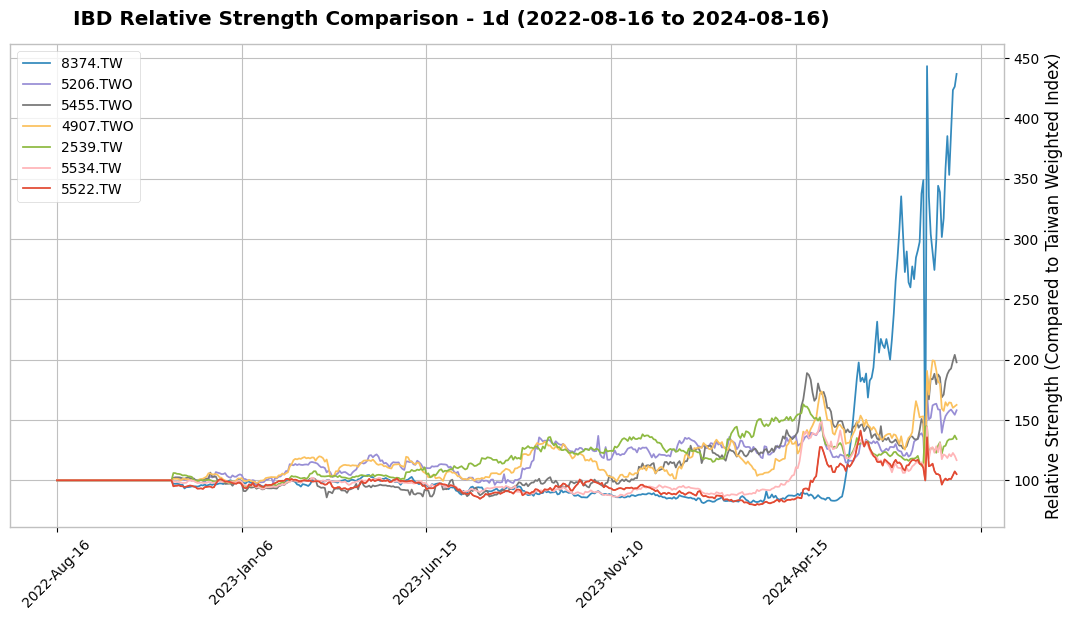

[********************* 44%%                      ]  4 of 9 completed

You can only select up to 8 stocks. Please deselect some items.


[*********************100%%**********************]  9 of 9 completed


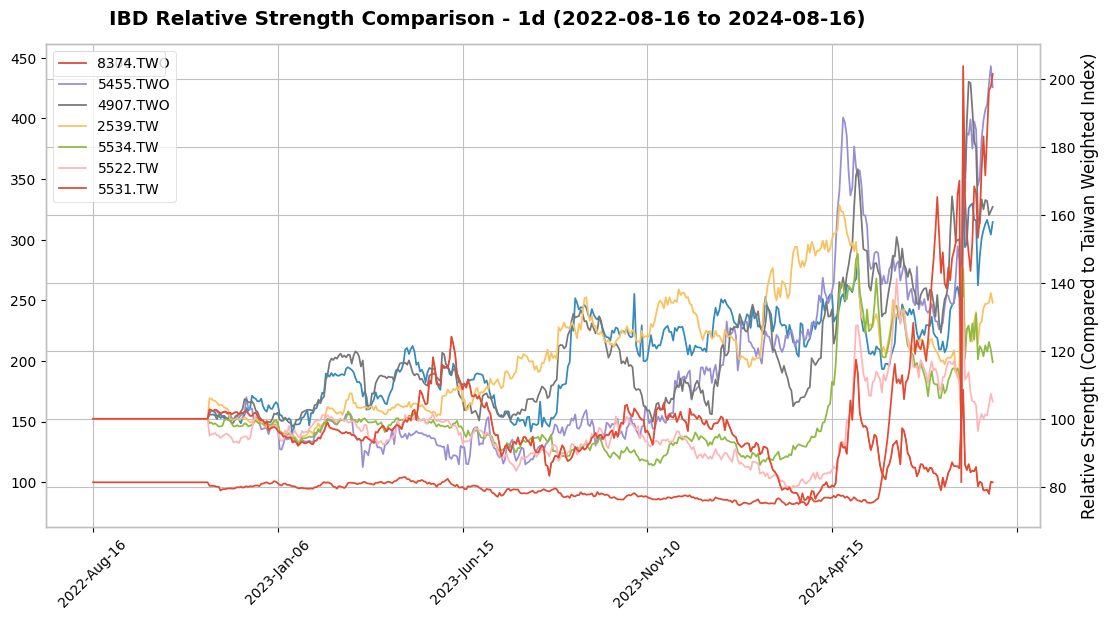

[**********************78%%***********           ]  7 of 9 completed

You can only select up to 8 stocks. Please deselect some items.


[*********************100%%**********************]  9 of 9 completed


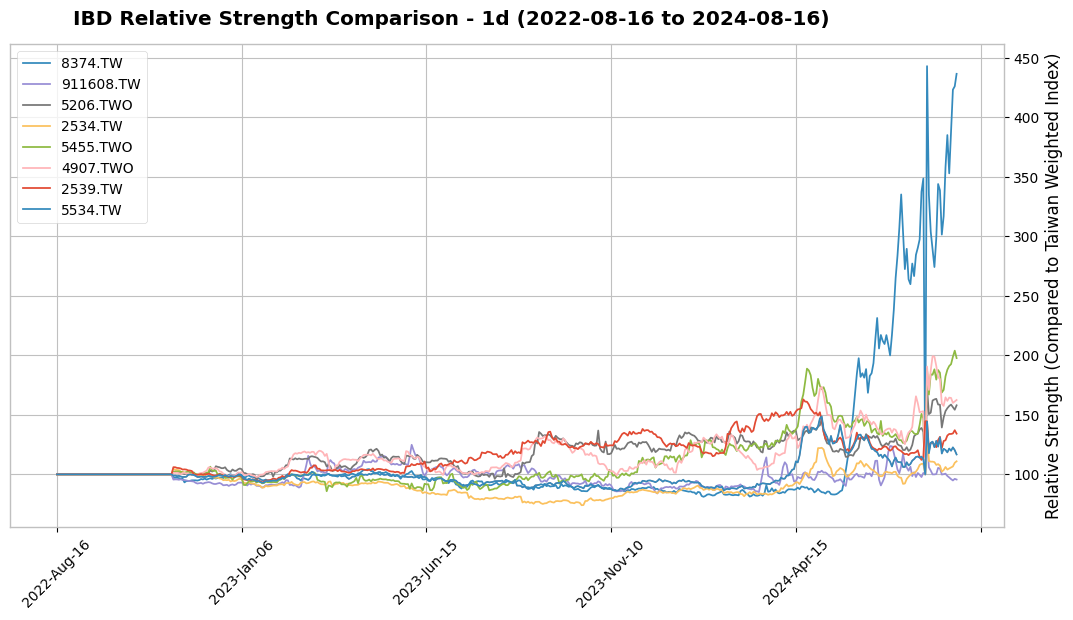

In [40]:
# @title Step 4. Show the Comparison of RS Lines {"run":"auto"}
period = "2y" # @param ["1y","2y","5y"]
interval = "1d" # @param ["1d","1wk"]
backend = "mplfinance" # @param ["mplfinance","Plotly"]

import ipywidgets as widgets

def get_tickers(df):
    return [ticker for sublist in df['Tickers']  for ticker in sublist]

def convert_to_list(value):
    if isinstance(value, str):
        return value.split(',')
    return value

# Define available stock tickers
tickers = OrderedSet()
if 'Ticker' in df_top.columns:
    tickers += OrderedSet(df_top['Ticker'])
elif 'Tickers' in df_top.columns:
    df_top['Tickers'] = df_top['Tickers'].apply(convert_to_list)
    tickers += OrderedSet(get_tickers(df_top))
if 'Ticker' in df_top_filtered.columns:
    tickers += OrderedSet(df_top_filtered['Ticker'])
elif 'Tickers' in df_top_filtered.columns:
    df_top_filtered['Tickers'] = df_top_filtered['Tickers'].apply(convert_to_list)
    tickers += OrderedSet(get_tickers(df_top_filtered))

available_tickers = [tw.stock_name(t) for t in tickers]

# Create checkboxes for stock selection
checkboxes = [
    widgets.Checkbox(value=False, description=ticker,
                     layout=widgets.Layout(width='auto', margin='2px'))
    for ticker in available_tickers
]

# Arrange checkboxes in a grid layout using GridBox
n_cols = 5  # Number of columns in the grid
n_rows = (len(checkboxes) + n_cols - 1) // n_cols  # Number of rows required

# Ensure all rows have the same number of columns
grid_items = [checkboxes[i:i + n_cols]
              for i in range(0, len(checkboxes), n_cols)]

# Fill any remaining cells with dummy widgets
for row in grid_items:
    while len(row) < n_cols:
        row.append(widgets.Label())  # Use Label as placeholder

# Ensure the number of rows is correct
while len(grid_items) < n_rows:
    grid_items.append([widgets.Label()] * n_cols)  # Add empty rows if necessary

# Flatten the grid_items list
flat_grid_items = [item for sublist in grid_items for item in sublist]

checkbox_grid = widgets.GridBox(flat_grid_items, layout=widgets.Layout(
    width='auto',
    grid_template_columns=f'repeat({n_cols}, 1fr)',
    grid_gap='10px'
))

# Button to confirm selection and plot
button = widgets.Button(description="Generate Plot")

# Create final layout combining grid and controls
layout = widgets.VBox([checkbox_grid, button])

# Display UI elements
display(layout)

def get_selected_stocks():
    selected_stocks = [checkbox.description
                       for checkbox in checkboxes if checkbox.value]
    return selected_stocks

def validate_selection(selected_stocks):
    if len(selected_stocks) > 8:
        print("You can only select up to 8 stocks. Please deselect some items.")
        return selected_stocks[:8]  # Limit to 8 items
    return selected_stocks


import vistock.mpl as vs_mpl
import vistock.plotly as vs_plotly


func_dic = {
    'mplfinance': vs_mpl.ibd_rs_cmp,
    'Plotly': vs_plotly.ibd_rs_cmp,
}
ibd_rs_cmp = func_dic[backend]

# Define the button click event
def on_button_click(b):
    selected_stocks = get_selected_stocks()
    symbols = validate_selection(selected_stocks)
    if not symbols:
        print("No stocks selected. Please select at least one stock.")
        return
    ibd_rs_cmp.plot(symbols, interval=interval, period=period)


button.on_click(on_button_click)

